In [188]:
#The code I used to generate example data 
# M = np.zeros((300, 4))
# K = np.load(namefile(2,3))
# for i in range(300):
#     M[i,0] = np.random.randint(low = 0, high = Ntimes)
#     M[i,1] = np.random.randint(low = 0, high = N)
#     M[i,2] = np.random.randint(low = 0, high = N)
#     M[i,3] = K[int(M[i,0]),int(M[i,1]),int(M[i,2])]
# M = np.unique(M, axis = 0)
#np.save('Example_data.npy', M)


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as t

#Parameters of the grid
Ntimes = 119
N = 80

#Change lines below to match name of the directory and names of the files

simulation_data_dir = "/home/pau/Documents/DataHotIPs/"
namefile = lambda i,j: simulation_data_dir + 'source_'+str(i)+'_'+str(j)+'.npy'

#measurement_data_file = "Example_data.npy"
measurement_data_file = "../data/pm25_processed_1day.npy"
measurement_array = np.load(measurement_data_file)


In [9]:
sorted_array = np.array(sorted(measurement_array, key = lambda x: (x[0], x[1], x[2])))
if (sorted_array != measurement_array).any():
    measurement_array = sorted_array
    print("Measurement array sorted")
measurement_array = measurement_array[0:1000]

Measurement array sorted


In [10]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def compute_posterior(prior, measurement_array, Sigma_noise, preload_sim_data = None):

    if preload_sim_data is None:
        #Will load the matrices from disk
        #I build the mask first
        measurement_mask = np.zeros((Ntimes, N, N)).astype(bool)
        for i in range(len(measurement_array)):
            measurement_mask[int(measurement_array[i,0]), int(measurement_array[i,1]), int(measurement_array[i,2])] = True
        get_measurements = lambda i,j: np.load(namefile(i,j))[measurement_mask]
    else:
        #preload_sim_data has to be (N,N,N_measurements)
        get_measurements = lambda i,j: preload_sim_data[i,j]
    
    data = measurement_array[:, -1] 
    
    Sigma_inv = np.linalg.inv(Sigma_noise)
    posterior = np.zeros((N,N))
    #I'm not sure if this can be vectorized more since I have to individually open and close files
    for i in t(range(N)):
        for j in range(N):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = get_measurements(i,j)
            posterior[i,j] = prior[i,j]*np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
    s = np.sum(posterior)
    posterior/= s
    return posterior

In [11]:
#Prior
#Example: uniform prior
prior = 1/N**2 * np.ones((N,N))

In [12]:
#How much noise do we assume that the measurements had? In units of the measurements
#Assuming here that all the sensors are independent and with the same noise
n_measurements = measurement_array.shape[0]
sigma = 0.01 
Sigma_noise = sigma**2*np.eye(n_measurements) 

In [13]:
posterior = compute_posterior(prior = prior, measurement_array=measurement_array, Sigma_noise=Sigma_noise)

  0%|          | 0/80 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/pau/Documents/DataHotIPs/source_0_0.npy'

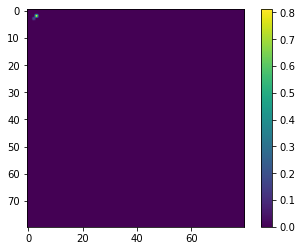

In [189]:
plt.imshow(posterior)
plt.colorbar()